In [2]:
import numpy as np 
from matplotlib import pyplot as plt 
import os 
import networkx as nx
import torch

/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project_dir = '../'

os.chdir(project_dir)

In [30]:
from datagen.missingData import mgraph, missing_value_dataset 
from datagen.graph import DirectedGraphGenerator
from datagen.structuralModels import linearSEM

from models.nodags.missing_data_model import missModel
from models.nodags.functions import gumbelSoftMLP
from models.nodags.resblock import iResBlock
from models.nodags.trainer import Trainer

from utils.error_metrics import *

## Generate Graph and Data

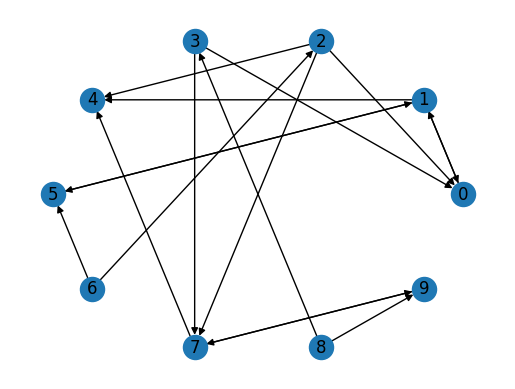

In [5]:
n_nodes = 10
graph_gen = DirectedGraphGenerator(
    nodes = n_nodes,
    expected_density = 2, 
    enforce_dag=False
)

graph = graph_gen()

pos = nx.circular_layout(graph)

fig, axs = plt.subplots(1)

nx.draw(graph, pos=pos, with_labels=True, ax=axs)

In [18]:
sem = linearSEM(
    graph=graph,
    abs_weight_low=0.6,
    noise_scale=0.1,
    contractive=True
)

intervention_targets = [[i] for i in range(n_nodes)]
intervention_datasets = list()

for target in intervention_targets:
    intervention_datasets.append(
        sem.generateData(n_samples=1000, intervention_set=target)
    )

In [19]:
mod_graph = mgraph(
    obs_graph=graph,
    sem=sem,
    missing_model='obs-only',
    p=0.1, 
    max_variance=0.1,
    is_mcar=False,
    max_child=2
)

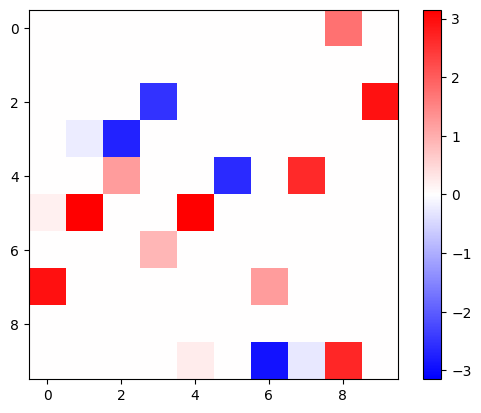

In [20]:
fig, axs = plt.subplots(1)

vmax = np.abs(mod_graph.m_coefs).max()
im = axs.imshow(mod_graph.m_coefs, vmin=-vmax, vmax=vmax, cmap='bwr')

_ = fig.colorbar(im)

In [21]:
interventional_datasets = list()

for targets, dataset in zip(intervention_targets, intervention_datasets):

    missing_mask, dataset_missing = mod_graph.generatemDataFromSamples(
        X=dataset,
        intervention_set=targets
    )
    
    interventional_datasets.append((dataset, missing_mask, dataset_missing))
    
training_dataset = missing_value_dataset(interventional_datasets, intervention_targets)

## Initializing the model

In [22]:
causal_mech = gumbelSoftMLP(
    n_nodes=n_nodes, 
    lip_constant=0.9
)

nodags = iResBlock(
    func=causal_mech, 
    n_power_series=None, 
    precondition=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nodags = nodags.to(device)

miss_model = missModel(nodags, is_mcar=False) # Set is_mcar to True to use MissDAG

## Training

In [23]:
model_trainer = Trainer(
    miss_model=miss_model,
    lr=1e-1,
    lambda_c=1e-2,
    lambda_dag=1.0,
    dag_method="expm",
    obs=False # set to True to use MissDAG
    max_epochs=100,
    batch_size=1024,
    n_lip_iters=5
)

In [24]:
X = training_dataset.X_miss 
R = training_dataset.R
S = training_dataset.intervention_mask

model_trainer.learn_missingness_mech(
    data=X,
    R=R,
    intervention_mask=S, # When using MissDAG the intervention mask is set to [None] since MissDAG does not handle interventions
    C=0.9
)

Text(0.5, 1.0, 'Est. params')

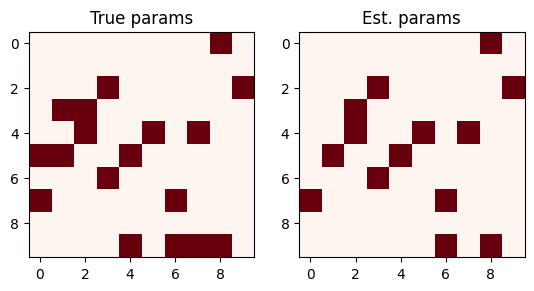

In [25]:
def normalize_mat(mat):

    return (mat - mat.min()) / (mat.max() - mat.min())

fig, axs = plt.subplots(1, 2)

threshold = 0.2

axs[0].imshow(normalize_mat(np.abs(mod_graph.m_coefs)) > 0, cmap='Reds')
axs[1].imshow(normalize_mat(np.abs(miss_model.coefs.numpy())) > threshold, cmap='Reds')

axs[0].set_title("True params")
axs[1].set_title("Est. params")

In [26]:
log_px, iter_count, acceptance_rate, repetitions_list = model_trainer.train(
    data=training_dataset,
    print_loss=True, 
    print_interval=100,
    data_missing=True,
    min_accept_factor=0.5
)

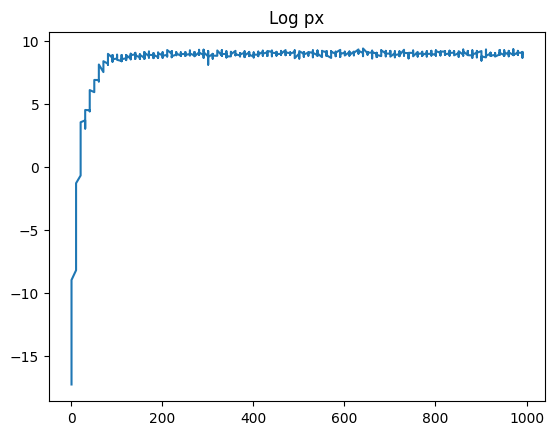

In [28]:
fig, axs = plt.subplots(1) 

axs.plot(iter_count, log_px)
axs.set_title("Log px")

plt.subplots_adjust(wspace=0.4)

Text(0.5, 1.0, 'Estimated')

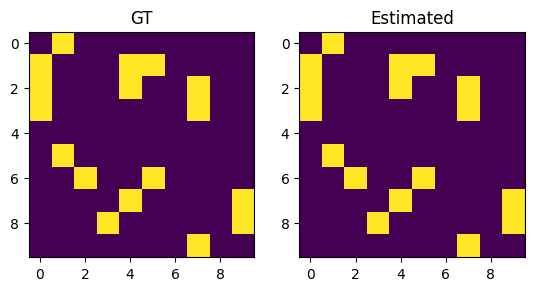

In [29]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(np.abs(sem.weights) > 0)
axs[0].set_title("GT")

axs[1].imshow(nodags.get_w_adj() > 0.9)
axs[1].set_title("Estimated")